Classification report for stolen detector:
              precision    recall  f1-score   support

       False      0.640     0.612     0.625      2000
        True      0.299     0.325     0.312      1021

    accuracy                          0.515      3021
   macro avg      0.470     0.468     0.468      3021
weighted avg      0.525     0.515     0.519      3021



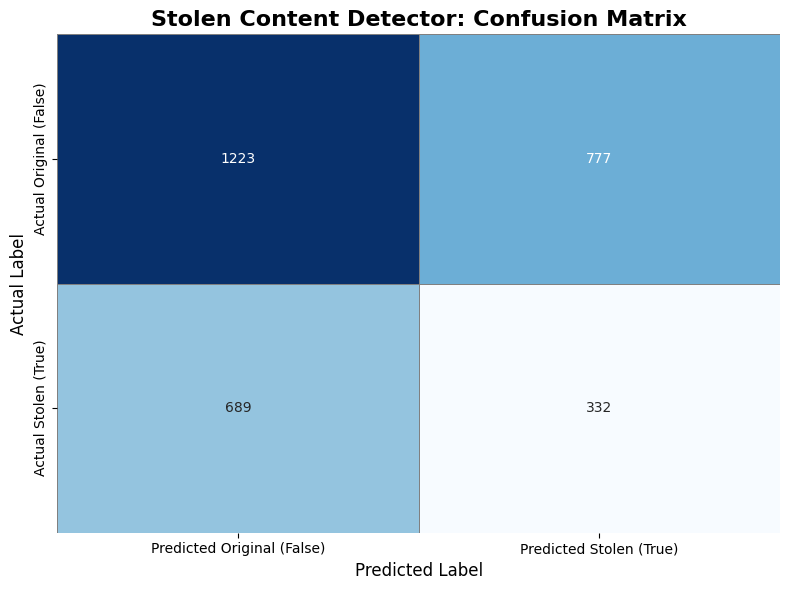

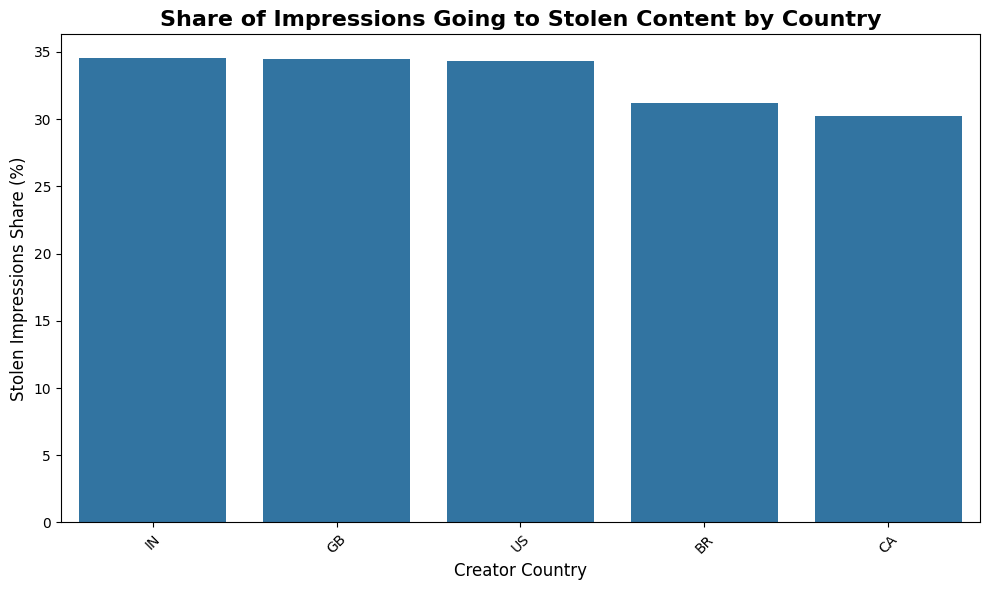


Policy metrics table:
                            Policy  Stolen_Impressions_Share  \
0                         Baseline                 33.573500   
1  Policy A: Hide Predicted Stolen                 35.549744   
2           Policy B: Downrank 50%                 34.340998   

   Original_Exposure_Index  
0               100.000000  
1                61.606336  
2                80.803168  


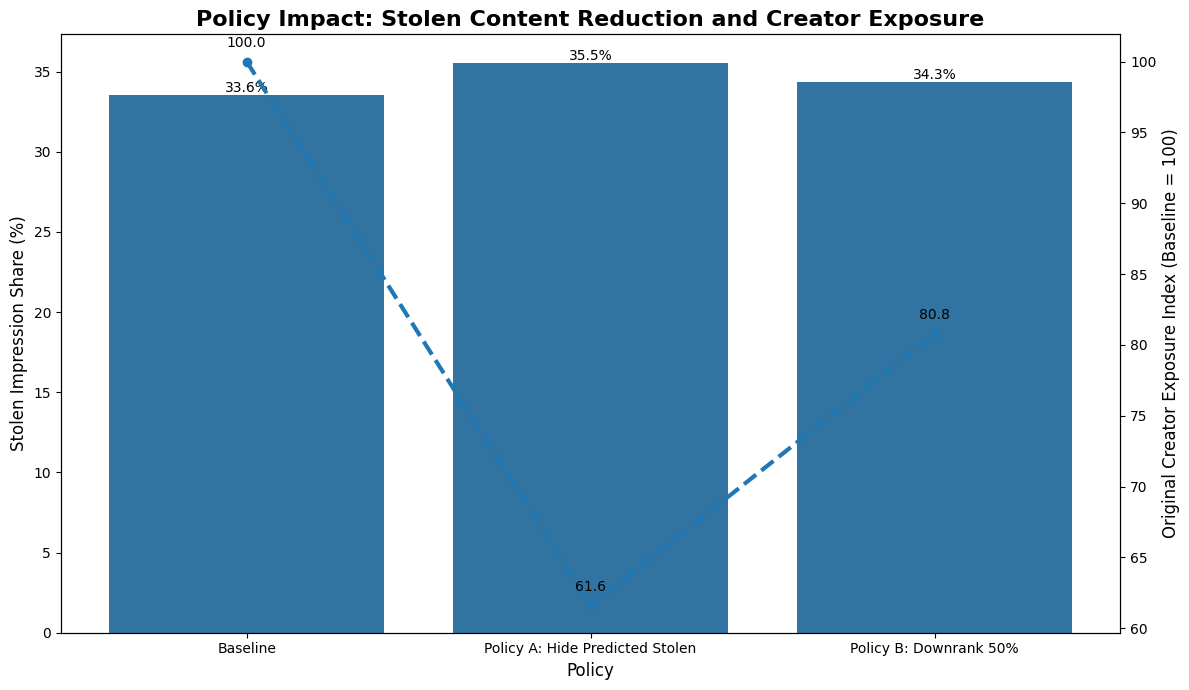

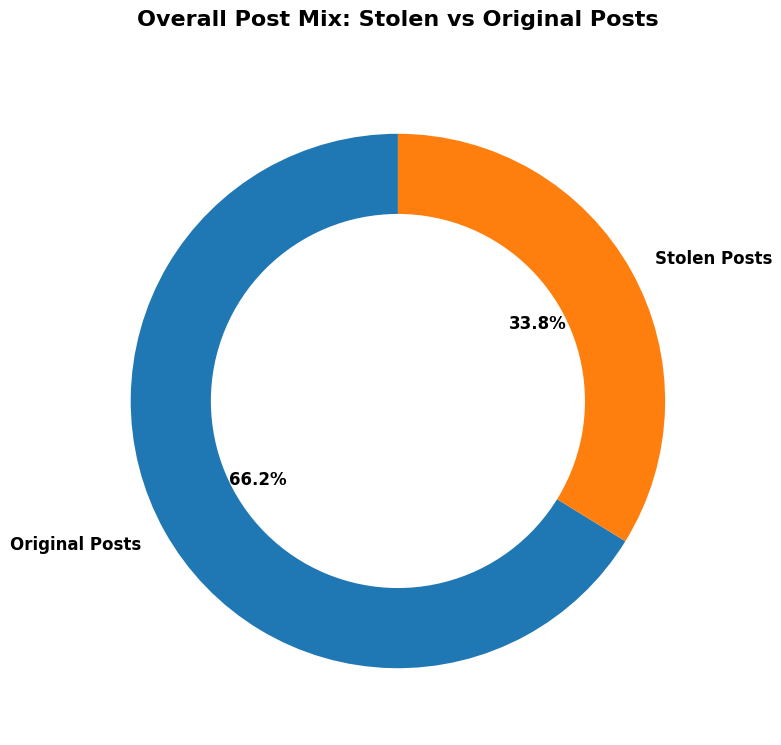

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

# Helper so everything works when this notebook lives in /notebooks
DATA_PREFIX = "../data"

# ========= 1. LOAD BASE DATA =========

df_posts = pd.read_csv(f"{DATA_PREFIX}/posts_with_predictions.csv")
df_impr = pd.read_csv(f"{DATA_PREFIX}/feed_impressions.csv")
df_users = pd.read_csv(f"{DATA_PREFIX}/users.csv")

# Make sure the key columns exist
assert "is_stolen" in df_posts.columns
assert "pred_is_stolen" in df_posts.columns
assert "post_id" in df_posts.columns
assert "post_id" in df_impr.columns
assert "author_id" in df_posts.columns
assert "user_id" in df_users.columns

# Merge impressions with post and creator info
impr_full = (
    df_impr
    .merge(
        df_posts[["post_id", "author_id", "is_stolen", "pred_is_stolen"]],
        on="post_id",
        how="left"
    )
    .merge(
        df_users[["user_id", "country"]],
        left_on="author_id",
        right_on="user_id",
        how="left"
    )
)

# ========= 2. CONFUSION MATRIX FOR DETECTOR =========

y_true = df_posts["is_stolen"].astype(bool)
y_pred = df_posts["pred_is_stolen"].astype(bool)

cm = confusion_matrix(y_true, y_pred, labels=[False, True])
cm_df = pd.DataFrame(
    cm,
    index=["Actual Original (False)", "Actual Stolen (True)"],
    columns=["Predicted Original (False)", "Predicted Stolen (True)"]
)

print("Classification report for stolen detector:")
print(classification_report(y_true, y_pred, digits=3))

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    linewidths=0.5,
    linecolor="gray"
)
plt.title("Stolen Content Detector: Confusion Matrix", fontsize=16, fontweight="bold")
plt.ylabel("Actual Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.tight_layout()
plt.show()

# ========= 3. HARM BY COUNTRY SUMMARY + CSV =========

# For each creator country measure how much of its feed share is stolen content
country_group = impr_full.groupby("country", dropna=False)

harm_by_country = (
    country_group
    .agg(
        total_impressions=("impression_id", "count"),
        stolen_impressions=("is_stolen", lambda s: s.fillna(False).sum())
    )
    .reset_index()
)

harm_by_country["stolen_impr_share_pct"] = (
    harm_by_country["stolen_impressions"]
    / harm_by_country["total_impressions"]
    * 100.0
)

# Save summary CSV so it exists on disk
harm_by_country.to_csv(f"{DATA_PREFIX}/harm_by_country_summary.csv", index=False)

# Bar chart
harm_sorted = harm_by_country.sort_values(
    "stolen_impr_share_pct",
    ascending=False
).head(15)  # top 15 countries

plt.figure(figsize=(10, 6))
sns.barplot(
    data=harm_sorted,
    x="country",
    y="stolen_impr_share_pct"
)
plt.title("Share of Impressions Going to Stolen Content by Country", fontsize=16, fontweight="bold")
plt.ylabel("Stolen Impressions Share (%)", fontsize=12)
plt.xlabel("Creator Country", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ========= 4. SIMPLE POLICY SIMULATION + CSV =========
# Three policies
# Baseline: current ranking, stolen posts weight 1.0
# Policy A: hide predicted stolen (weight 0 for impressions where pred_is_stolen True)
# Policy B: downrank predicted stolen by 50 percent (weight 0.5)

# Baseline original exposure (for index)
baseline_weights = np.ones(len(impr_full))
baseline_original_weight = baseline_weights[~impr_full["is_stolen"]].sum()

def policy_metrics(name, stolen_weight_for_pred):
    # weight stolen impressions based on pred_is_stolen
    weights = np.where(impr_full["pred_is_stolen"], stolen_weight_for_pred, 1.0)
    total_weight = weights.sum()
    stolen_weight = weights[impr_full["is_stolen"]].sum()
    original_weight = weights[~impr_full["is_stolen"]].sum()

    stolen_share_pct = stolen_weight / total_weight * 100.0
    original_exposure_index = original_weight / baseline_original_weight * 100.0

    return {
        "Policy": name,
        "Stolen_Impressions_Share": stolen_share_pct,
        "Original_Exposure_Index": original_exposure_index,
    }

policy_rows = [
    policy_metrics("Baseline", 1.0),
    policy_metrics("Policy A: Hide Predicted Stolen", 0.0),
    policy_metrics("Policy B: Downrank 50%", 0.5),
]

df_policy = pd.DataFrame(policy_rows)

# Save summary CSV so it exists on disk
df_policy.to_csv(f"{DATA_PREFIX}/policy_metrics_summary.csv", index=False)

print("\nPolicy metrics table:")
print(df_policy)

# Policy comparison plot
policy_order = [
    "Baseline",
    "Policy A: Hide Predicted Stolen",
    "Policy B: Downrank 50%"
]
df_policy["Policy"] = pd.Categorical(df_policy["Policy"], categories=policy_order, ordered=True)
df_policy = df_policy.sort_values("Policy")

fig, ax1 = plt.subplots(figsize=(12, 7))

sns.barplot(
    data=df_policy,
    x="Policy",
    y="Stolen_Impressions_Share",
    ax=ax1
)
ax1.set_ylabel("Stolen Impression Share (%)", fontsize=12)
ax1.set_xlabel("Policy", fontsize=12)

for bar in ax1.patches:
    height = bar.get_height()
    ax1.annotate(
        f"{height:.1f}%",
        (bar.get_x() + bar.get_width() / 2, height),
        ha="center",
        va="bottom",
        fontsize=10
    )

ax2 = ax1.twinx()
ax2.plot(
    df_policy["Policy"],
    df_policy["Original_Exposure_Index"],
    marker="o",
    linestyle="--",
    linewidth=3
)
ax2.set_ylabel("Original Creator Exposure Index (Baseline = 100)", fontsize=12)

for x, y in enumerate(df_policy["Original_Exposure_Index"].tolist()):
    ax2.annotate(
        f"{y:.1f}",
        (x, y + 1),
        ha="center",
        fontsize=10
    )

plt.title("Policy Impact: Stolen Content Reduction and Creator Exposure", fontsize=16, fontweight="bold")
plt.xticks(rotation=15)
fig.tight_layout()
plt.show()

# ========= 5. OVERALL POST MIX DONUT CHART =========

post_mix = df_posts["is_stolen"].value_counts()
labels = ["Original Posts", "Stolen Posts"]
sizes = [post_mix.get(False, 0), post_mix.get(True, 0)]

fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops=dict(width=0.4),
    textprops={"fontsize": 12, "fontweight": "bold"}
)
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig.gca().add_artist(centre_circle)
ax.set_title("Overall Post Mix: Stolen vs Original Posts", fontsize=16, fontweight="bold", y=1.05)
plt.tight_layout()
plt.show()
